In [ ]:
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset

Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset
License(s): CC0-1.0
  0% 0.00/6.03M [00:00<?, ?B/s]
100% 6.03M/6.03M [00:00<00:00, 156MB/s]


In [ ]:
!unzip ./diabetes-health-indicators-dataset.zip -d ./diabetes-health-indicators-dataset

Archive:  ./diabetes-health-indicators-dataset.zip
  inflating: ./diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv  
  inflating: ./diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv  
  inflating: ./diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv  


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

np.random.seed(42)
#from ydata_profiling import ProfileReport

In [ ]:
features = pd.read_csv('/content/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

# EDA

# PreProcessing


In [ ]:
# gộp
features.loc[features['Education'] < 3, 'Education'] = 3


In [ ]:
features.drop_duplicates(inplace=True)
features.reset_index(drop=True, inplace=True)

In [ ]:
# loại bỏ các dữ liệu trùng lặp
features.drop_duplicates(inplace=True)
features.reset_index(drop=True, inplace=True)
Sscaler = StandardScaler()
Rscaler = RobustScaler()
Mscaler = MinMaxScaler()
features_standardized = pd.DataFrame(Sscaler.fit_transform(features), columns=features.columns)
features_robust = pd.DataFrame(Rscaler.fit_transform(features), columns=features.columns)
features_MinMax = pd.DataFrame(Mscaler.fit_transform(features), columns=features.columns)



features[['BMI', 'Age', 'GenHlth']] = features_standardized[['BMI', 'Age', 'GenHlth']]
features[['MentHlth', 'PhysHlth']] = features_robust[['MentHlth', 'PhysHlth']]
features[['Education', 'Income']] = features_MinMax[['Education', 'Income']]


# chia tập thành train | test

# chia tập thành train | val | test

In [ ]:
class_0 = features[features['Diabetes_binary'] == 0]
class_1 = features[features['Diabetes_binary'] == 1]

x_class_0, y_class_0 = class_0.drop(columns=['Diabetes_binary'], axis=1), class_0['Diabetes_binary']
x_class_1, y_class_1 = class_1.drop(columns=['Diabetes_binary'], axis=1), class_1['Diabetes_binary']

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_class_0, y_class_0, test_size=0.2, random_state=1)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_class_1, y_class_1, test_size=0.2, random_state=1)

x_0_train, x_0_val, y_0_train, y_0_val = train_test_split(x_0_train, y_0_train, test_size=0.25, random_state=1)
x_1_train, x_1_val, y_1_train, y_1_val = train_test_split(x_1_train, y_1_train, test_size=0.25, random_state=1)



x_train = pd.concat(objs=[x_0_train, x_1_train], ignore_index=True).to_numpy()
y_train = pd.concat(objs=[y_0_train, y_1_train], ignore_index=True).to_numpy()
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]

x_val = pd.concat(objs=[x_0_val, x_1_val], ignore_index=True).to_numpy()
y_val = pd.concat(objs=[y_0_val, y_1_val], ignore_index=True).to_numpy()
index = np.arange(x_val.shape[0])
np.random.shuffle(index)
x_val = x_val[index]
y_val = y_val[index]

x_test = pd.concat(objs=[x_0_test, x_1_test], ignore_index=True).to_numpy()
y_test = pd.concat(objs=[y_0_test, y_1_test], ignore_index=True).to_numpy()
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [ ]:
# GAUSSIAN
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
gnb = GaussianNB()

param_grid = {
    'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid_search = GridSearchCV(
    estimator=gnb,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)


grid_search.fit(x_train, y_train)


best_gnb = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)



print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'var_smoothing': 1e-06}
Best Parameters: {'var_smoothing': 1e-06}


In [ ]:
models = {
    "GaussianNB": best_gnb,
    #"RandomForest": best_rf,
    # "WeightedGaussianNB": best_wgnb,
    # "TransformedGaussianNB": best_tgnb,
    # # "MultinomialNB": best_mnb,
    # "BernoulliNB": best_bnb
}

results = {}

for model_name, model in models.items():
    #model.fit(x_train, y_train)
    y_pred = model.predict(x_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')

    results[model_name] = {
        "model": model,
        "accuracy": accuracy,
        "f1_score": f1,
        "classification_report": classification_report(y_val, y_pred, output_dict=True)
    }
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}\n")



Model: GaussianNB
Accuracy: 0.7181, F1 Score: 0.7180
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71      6792
         1.0       0.72      0.72      0.72      7019

    accuracy                           0.72     13811
   macro avg       0.72      0.72      0.72     13811
weighted avg       0.72      0.72      0.72     13811




In [ ]:
from sklearn.inspection import permutation_importance

best_model_name = max(results, key=lambda m: results[m]["f1_score"])
best_model = results[best_model_name]["model"]
print(f"\nBest Model: {best_model_name}")

result = permutation_importance(best_model, x_val, y_val, n_repeats=50, random_state=42, scoring='f1_macro', n_jobs=-1)

sorted_idx = result.importances_mean.argsort()
feature_importances = result.importances_mean
features_w = features.drop(columns=['Diabetes_binary'], axis=1).columns

importance_df  = pd.DataFrame({
    'Feature': features_w,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
# Hiển thị kết quả
for i in result.importances_mean.argsort()[::-1]:
    print(f"Đặc trưng {features.columns[i+1]}: {result.importances_mean[i]:.4f} +-  {result.importances_std[i]:.4f}")



Best Model: GaussianNB
Đặc trưng HighBP: 0.0177 +-  0.0016
Đặc trưng HeartDiseaseorAttack: 0.0136 +-  0.0018
Đặc trưng GenHlth: 0.0125 +-  0.0022
Đặc trưng BMI: 0.0125 +-  0.0014
Đặc trưng Stroke: 0.0112 +-  0.0012
Đặc trưng Age: 0.0106 +-  0.0011
Đặc trưng HvyAlcoholConsump: 0.0087 +-  0.0011
Đặc trưng HighChol: 0.0085 +-  0.0012
Đặc trưng CholCheck: 0.0075 +-  0.0010
Đặc trưng DiffWalk: 0.0031 +-  0.0016
Đặc trưng PhysHlth: 0.0018 +-  0.0015
Đặc trưng Sex: 0.0009 +-  0.0004
Đặc trưng PhysActivity: 0.0009 +-  0.0009
Đặc trưng Veggies: 0.0007 +-  0.0007
Đặc trưng AnyHealthcare: 0.0007 +-  0.0008
Đặc trưng Income: 0.0003 +-  0.0011
Đặc trưng Smoker: 0.0003 +-  0.0006
Đặc trưng Fruits: 0.0000 +-  0.0005
Đặc trưng NoDocbcCost: -0.0003 +-  0.0007
Đặc trưng Education: -0.0004 +-  0.0011
Đặc trưng MentHlth: -0.0021 +-  0.0010


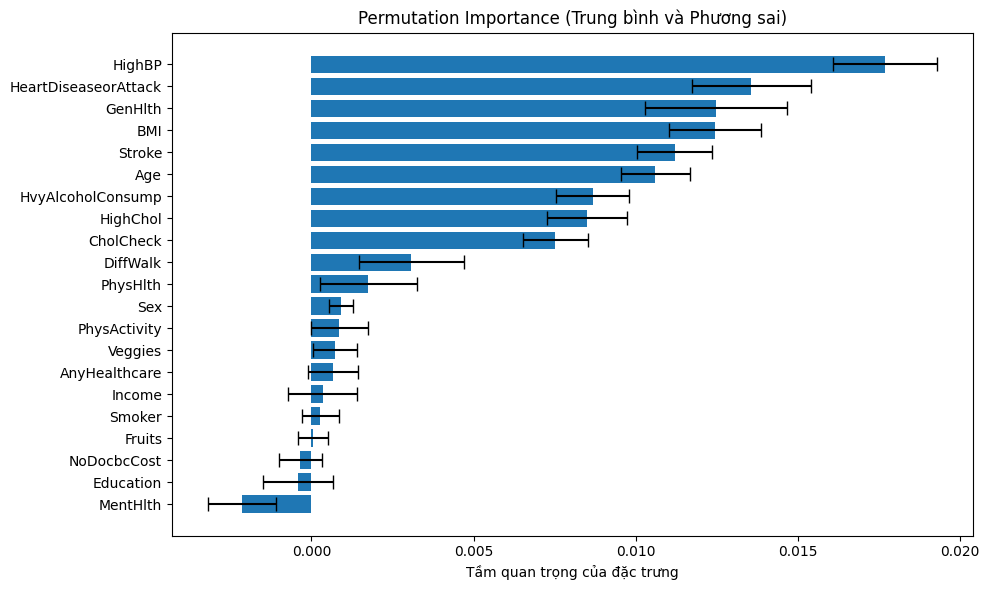

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử `result.importances_mean` là giá trị trung bình và `result.importances_std` là phương sai
means = result.importances_mean[sorted_idx]
stds = result.importances_std[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(
    range(len(sorted_idx)),
    means,
    xerr=stds,  # Thêm phương sai vào đây
    align="center",
    alpha=1,  # Tùy chỉnh độ trong suốt
    capsize=5  # Kích thước các đường gạch ngang của lỗi
)
plt.yticks(range(len(sorted_idx)), [features.columns[i+1] for i in sorted_idx])
plt.xlabel("Tầm quan trọng của đặc trưng")
plt.title("Permutation Importance (Trung bình và Phương sai)")
plt.tight_layout()
plt.savefig('importances2.png')
plt.show()

In [ ]:
low_importance_features = importance_df[importance_df['Importance'] <= 0]

# Get the list of feature names
low_importance_feature_names = low_importance_features['Feature'].tolist()
print(low_importance_feature_names)


['NoDocbcCost', 'Education', 'MentHlth']


In [ ]:
x_train = pd.DataFrame(x_train, columns = features.drop(columns=['Diabetes_binary'], axis=1).columns)
y_train = pd.DataFrame(y_train, columns = ["Diabetes_binary"])
x_val = pd.DataFrame(x_val, columns = features.drop(columns=['Diabetes_binary'], axis=1).columns)
y_val = pd.DataFrame(y_val, columns = ["Diabetes_binary"])
x_test = pd.DataFrame(x_test, columns = features.drop(columns=['Diabetes_binary'], axis=1).columns)
y_test = pd.DataFrame(y_test, columns = ["Diabetes_binary"])

In [ ]:
x_combined = pd.concat([x_train, x_val], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)
x_test = x_test

models = {
    "GaussianNB": best_gnb,
    #"RandomForest": best_rf
    # "WeightedGaussianNB": best_wgnb,
    # "TransformedGaussianNB": best_tgnb,
    # # "MultinomialNB": best_mnb,
    # "BernoulliNB": best_bnb
}

results = {}

for model_name, model in models.items():
    model.fit(x_combined.to_numpy(), y_combined.to_numpy())
    y_pred = model.predict(x_test.to_numpy())

    accuracy = accuracy_score(y_test.to_numpy(), y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    results[model_name] = {
        "model": model,
        "accuracy": accuracy,
        "f1_score": f1,
        "classification_report": classification_report(y_test.to_numpy(), y_pred, output_dict=True)
    }

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{classification_report(y_test.to_numpy(), y_pred)}\n")



Model: GaussianNB
Accuracy: 0.7255, F1 Score: 0.7255
Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.73      0.72      6792
         1.0       0.73      0.72      0.73      7019

    accuracy                           0.73     13811
   macro avg       0.73      0.73      0.73     13811
weighted avg       0.73      0.73      0.73     13811




/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
x_combined = pd.concat([x_train, x_val], axis=0).drop(columns=low_importance_feature_names)
y_combined = pd.concat([y_train, y_val], axis=0)
x_test = x_test.drop(columns=low_importance_feature_names)

models = {
    "GaussianNB": best_gnb,
    #"RandomForest": best_rf
    # "WeightedGaussianNB": best_wgnb,
    # "TransformedGaussianNB": best_tgnb,
    # # "MultinomialNB": best_mnb,
    # "BernoulliNB": best_bnb
}

results = {}

for model_name, model in models.items():
    model.fit(x_combined.to_numpy(), y_combined.to_numpy())
    y_pred = model.predict(x_test.to_numpy())

    accuracy = accuracy_score(y_test.to_numpy(), y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    results[model_name] = {
        "model": model,
        "accuracy": accuracy,
        "f1_score": f1,
        "classification_report": classification_report(y_test.to_numpy(), y_pred, output_dict=True)
    }

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{classification_report(y_test.to_numpy(), y_pred)}\n")



Model: GaussianNB
Accuracy: 0.7315, F1 Score: 0.7314
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.72      0.73      6792
         1.0       0.73      0.74      0.74      7019

    accuracy                           0.73     13811
   macro avg       0.73      0.73      0.73     13811
weighted avg       0.73      0.73      0.73     13811




/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
